In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!ls '/content/drive/My Drive/plantvillage-new.zip'

'/content/drive/My Drive/plantvillage-new.zip'


In [ ]:
import zipfile

tomato = '/content/drive/My Drive/plantvillage-new.zip'

zip_ref = zipfile.ZipFile(tomato,'r')
zip_ref.extractall('/tmp/plantvillage-dataset')
zip_ref.close()

In [ ]:
!ls "/tmp/plantvillage-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"

 Tomato___Bacterial_spot   Tomato___Septoria_leaf_spot
 Tomato___Early_blight	  'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___healthy	   Tomato___Target_Spot
 Tomato___Late_blight	   Tomato___Tomato_mosaic_virus
 Tomato___Leaf_Mold	   Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [ ]:
# Import OS module
import os

# Imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Notebook magic
%matplotlib inline

In [ ]:

image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)

batch_size = 32

In [ ]:
import os
dataset_root = "/tmp/plantvillage-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/"

train_dir = os.path.join(dataset_root, "train")
test_dir = os.path.join(dataset_root, "valid")

In [ ]:
#DARK  images sekitar 40%

In [ ]:

train_aug = ImageDataGenerator(
    
    rescale=1/255.0,
    fill_mode="nearest",
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.4,1.0]
)


train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

test_aug = ImageDataGenerator(

    rescale=1/255.0
)


test_data = test_aug.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)


Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


In [ ]:
categories = list(train_data.class_indices.keys())
print(train_data.class_indices)

{'Tomato___Bacterial_spot': 0, 'Tomato___Early_blight': 1, 'Tomato___Late_blight': 2, 'Tomato___Leaf_Mold': 3, 'Tomato___Septoria_leaf_spot': 4, 'Tomato___Spider_mites Two-spotted_spider_mite': 5, 'Tomato___Target_Spot': 6, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato___Tomato_mosaic_virus': 8, 'Tomato___healthy': 9}


In [ ]:
# Load the base model
mbnet_v2 = keras.applications.MobileNet(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Stop from being trainable
mbnet_v2.trainable = False

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
mbnet_v2.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = mbnet_v2(inputs, training = False)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(categories), activation="softmax")(x) #CATEGORY TADI DIPAKE DISINI

# Combine the model
model = keras.Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 10)                10250     
                                                                 
Total params: 3,239,114
Trainable params: 10,250
Non-trainabl

In [ ]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)



In [ ]:
# Num epochs
epochs = 25

# Train model
history = model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=150,
    validation_steps=100,
    validation_data= test_data
    # callbacks=[early_stopping_cb]
)

Epoch 1/25
150/150 [==============================] - 95s 567ms/step - loss: 1.4537 - accuracy: 0.4946 - val_loss: 0.8132 - val_accuracy: 0.7378
Epoch 2/25
150/150 [==============================] - 83s 554ms/step - loss: 0.8196 - accuracy: 0.7275 - val_loss: 0.6154 - val_accuracy: 0.7962
Epoch 3/25
150/150 [==============================] - 80s 536ms/step - loss: 0.6390 - accuracy: 0.7819 - val_loss: 0.5473 - val_accuracy: 0.8153
Epoch 4/25
150/150 [==============================] - 82s 547ms/step - loss: 0.5783 - accuracy: 0.8123 - val_loss: 0.5128 - val_accuracy: 0.8238
Epoch 5/25
150/150 [==============================] - 83s 554ms/step - loss: 0.5077 - accuracy: 0.8323 - val_loss: 0.4330 - val_accuracy: 0.8528
Epoch 6/25
150/150 [==============================] - 83s 556ms/step - loss: 0.4870 - accuracy: 0.8396 - val_loss: 0.3910 - val_accuracy: 0.8684
Epoch 7/25
150/150 [==============================] - 82s 549ms/step - loss: 0.4643 - accuracy: 0.8390 - val_loss: 0.3796 - val_ac

In [ ]:
model.evaluate(test_data)


144/144 [==============================] - 13s 88ms/step - loss: 0.2785 - accuracy: 0.9023


[0.2784789800643921, 0.9022901058197021]

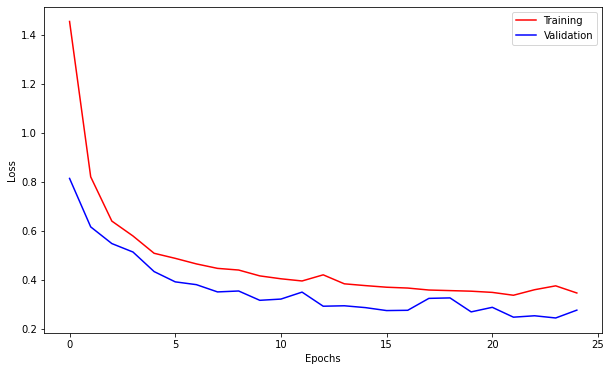

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

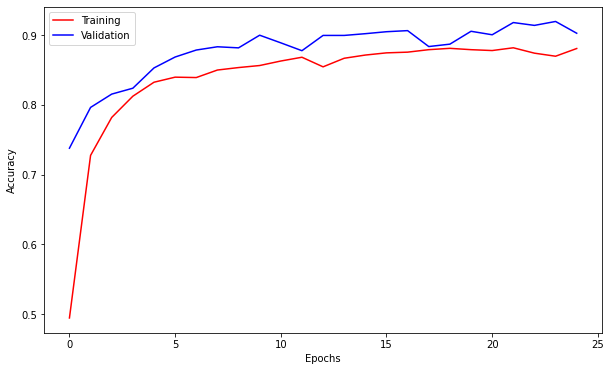

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

#BISA DIJADIIN PERTIMBANGAN BUAT TEST IMAGES SAMA CELL YG DIATAS JUGAAAAAA

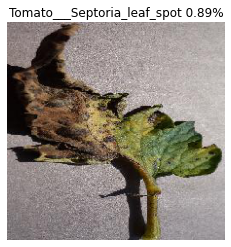

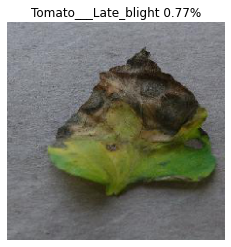

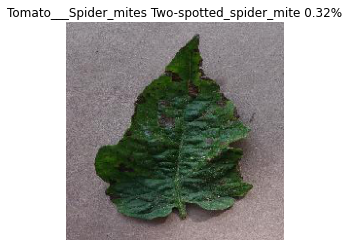

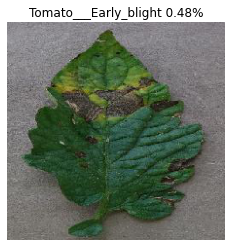

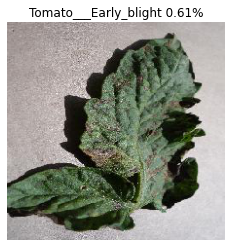

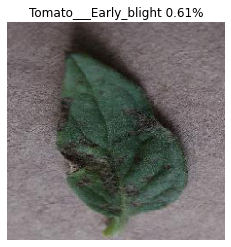

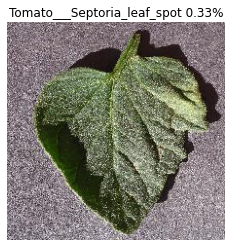

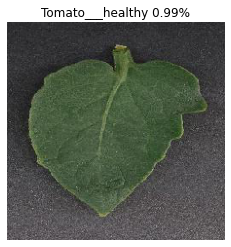

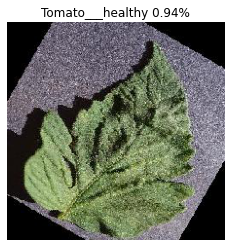

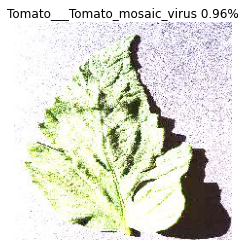

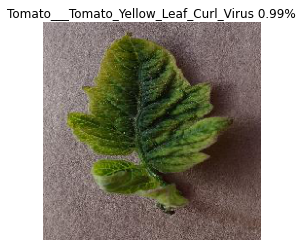

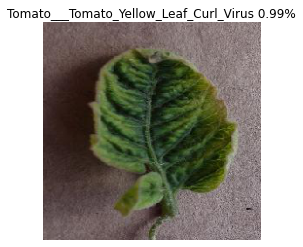

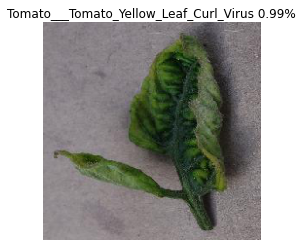

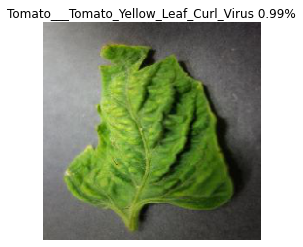

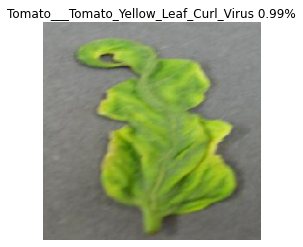

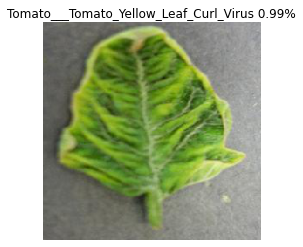

In [ ]:
# predicting an image
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
directory="/tmp/plantvillage-dataset/test/test"
# directory="/content/test_data/test/test"

files = [os.path.join(directory,p) for p in sorted(os.listdir(directory))]
for i in range(0,16):
    image_path = files[i]
    new_img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(new_img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    prediction = model.predict(img)
    probabilty = prediction.flatten()
    max_prob = probabilty.max()
    index=prediction.argmax(axis=-1)[0]
    class_name = categories[index]
    #ploting image with predicted class name        
    plt.figure(figsize = (4,4))
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(class_name+" "+ str(max_prob)[0:4]+"%")
    plt.show()
        

In [ ]:
from pathlib import Path
import pathlib

export_dir = '/saved_model'

# YOUR CODE HERE
tf.saved_model.save(model, export_dir)

# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Save the model.
tflite_model_file = pathlib.Path('/saved_model/tomato_disease.tflite')
tflite_model_file.write_bytes(tflite_model)


In [ ]:
# Install Tensorflow.js
!pip install tensorflowjs

In [ ]:
import tensorflowjs as tfjs
import tensorflow as tf
import os
tfjs.converters.save_keras_model(model, '/content/tfjs/')

In [ ]:
!zip -r /content/tfjs-tomato_disease.zip /content/tfjs/

In [ ]:
model.save('models/mobilenet_model.h5')

In [ ]:
!mkdir tensorflowjs-model

In [ ]:
!tensorflowjs_converter --input_format keras models/mobilenet_model.h5 tensorflowjs-model/

In [ ]:
!zip -r tensorflowjs-model/tfjs-tomato_disease2.zip tensorflowjs-model/